In [2]:
import re 
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
final = ""
with open("/kaggle/input/shakespeare/Shakespeare.txt","r") as file:
    text = file.read()
    text = text.lower()
    filtered_text = re.sub(r'\n[^:\n]+:\s*', '\n', text)
    filtered_text = filtered_text.replace('\n', ' ')
    filtered_text = re.sub(r"[^a-zA-Z0-9 \.'']", '', filtered_text)

In [4]:
filtered_text = filtered_text[14:]
filtered_text[:100]

'before we proceed any further hear me speak.  speak speak.  you are all resolved rather to die than '

In [63]:
with open("Shakespeare_Clean", 'w') as file:
    file.write(filtered_text)

In [5]:
filtered_text[:1000]

"before we proceed any further hear me speak.  speak speak.  you are all resolved rather to die than to famish  resolved. resolved.  first you know caius marcius is chief enemy to the people.  we know't we know't.  let us kill him and we'll have corn at our own price. is't a verdict  no more talking on't let it be done away away  one word good citizens.  we are accounted poor citizens the patricians good. if they would yield us but the superfluity while it were wholesome we might guess they relieved us humanely the leanness that afflicts us the object of our misery is as an inventory to particularise their abundance our sufferance is a gain to them let us revenge this with for the gods know i speak this in hunger for bread not in thirst for revenge.  would you proceed especially against caius marcius  against him first he's a very dog to the commonalty.  consider you what services he has done for his country  very well and could be content to give him good report fort but that he pays 

In [6]:
k = 1
emb_dim = 128
context_window = 5

In [8]:
import spacy

# Load the SpaCy English language model
nlp = spacy.load("en_core_web_sm")

# Set a higher maximum length
nlp.max_length = 3827926  # or some value larger than the length of your text

# Lowercase the text and process it using the SpaCy model
doc = nlp(text.lower())  # `text` should be your Shakespeare corpus


In [11]:
import torch
import torch.nn.functional as F
from spacy.lang.en import English
from collections import defaultdict

sentences = [sent.text for sent in doc.sents]  # Extract sentences

# Step 2: Tokenize each sentence into words using SpaCy
tokens_per_sentence = [[token.text for token in nlp(sentence)] for sentence in sentences]

# Step 3: Build the vocabulary (assign a unique index to each word)
word2idx = defaultdict(lambda: len(word2idx))  # Unique index for each word
word2idx['<pad>']  # Padding index should be 0

# Convert sentences to indexed tokens
indexed_sentences = [[word2idx[word] for word in sentence] for sentence in tokens_per_sentence]
vocab_size = len(word2idx)

# Step 4: Create context-target pairs (with sentence boundary handling)
def create_context_target_pairs(indexed_sentences, context_window):
    context_target_pairs = []
    
    for sentence in indexed_sentences:
        for i in range(context_window, len(sentence)):
            # Extract context (the last `context_window` words)
            context = sentence[i - context_window:i]
            target = sentence[i]  # Next word is the target
            
            context_target_pairs.append((context, target))
        
        # Padding for the last few words in the sentence
        if len(sentence) < context_window:
            context = F.pad(torch.tensor(sentence), (0, context_window - len(sentence)), value=0).tolist()
            context_target_pairs.append((context, 0))  # Target is 0 since no word follows

    return context_target_pairs

# Create context-target pairs
context_target_pairs = create_context_target_pairs(indexed_sentences, context_window)


In [12]:
word2idx

defaultdict(<function __main__.<lambda>()>,
            {'<pad>': 0,
             'before': 1,
             'we': 2,
             'proceed': 3,
             'any': 4,
             'further': 5,
             'hear': 6,
             'me': 7,
             'speak': 8,
             '.': 9,
             ' ': 10,
             'you': 11,
             'are': 12,
             'all': 13,
             'resolved': 14,
             'rather': 15,
             'to': 16,
             'die': 17,
             'than': 18,
             'famish': 19,
             'first': 20,
             'know': 21,
             'caius': 22,
             'marcius': 23,
             'is': 24,
             'chief': 25,
             'enemy': 26,
             'the': 27,
             'people': 28,
             "know't": 29,
             'let': 30,
             'us': 31,
             'kill': 32,
             'him': 33,
             'and': 34,
             "'ll": 35,
             'have': 36,
             'corn': 37,
             

In [13]:
vocab_size

25962

In [15]:
len(context_target_pairs)

632785

In [16]:
X = torch.from_numpy(np.array([char[0] for char in context_target_pairs]))
Y = torch.from_numpy(np.array([char[1] for char in context_target_pairs]))

In [19]:
X.to(device)

tensor([[   1,    2,    3,    4,    5],
        [   2,    3,    4,    5,    6],
        [   3,    4,    5,    6,    7],
        ...,
        [4302,   16, 1925,  198,  179],
        [  16, 1925,  198,  179,   64],
        [1925,  198,  179,   64,  260]], device='cuda:0')

In [20]:
Y.to(device)

tensor([  6,   7,   8,  ...,  64, 260,   9], device='cuda:0')

In [21]:
X.shape

torch.Size([632785, 5])

In [22]:
Y.shape

torch.Size([632785])

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
class NextWord(torch.nn.Module):
    def __init__(self, context_window, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = torch.nn.Embedding(vocab_size, emb_dim)
        self.lin1 = torch.nn.Linear(context_window * emb_dim, hidden_size)
        self.lin2 = torch.nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)  # Convert word indices into embeddings
        x = x.view(x.shape[0], -1)  # Flatten embeddings for each context window
        x = torch.relu(self.lin1(x))  # Apply first linear transformation + ReLU
        x = self.lin2(x)  # Output logits for each word in vocab
        return x


In [25]:
model = NextWord(context_window, vocab_size, emb_dim, 128).to(device)

In [26]:
model = model.to(device)

In [27]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='none')  # Use 'none' to compute the loss per element
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time

# Mini-batch training
batch_size = 4096
print_every = 100
elapsed_time = []

for epoch in range(10000):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size].to(device)  # Get the input batch
        y = Y[i:i+batch_size].to(device).long()  # Get the target batch, ensure long type
        
        # Create a mask to ignore padding in input (padding value is 0)
        mask = (x != 0).float()  # Mask: 1 for non-padding tokens, 0 for padding
        
        # Forward pass
        # Forward pass
        y_pred = model(x)  # Get predictions (shape: [batch_size, vocab_size])
        
        # Compute the loss directly without transposing
        loss_per_token = loss_fn(y_pred, y)  # Shape should be [batch_size]
        
        # Apply the mask to ignore padding
        # Reshape the mask to match the loss_per_token dimensions
        mask_flat = mask.sum(dim=1)  # Sum over context window to get a [batch_size] tensor
        masked_loss = loss_per_token * mask_flat  # Element-wise multiplication
        
        # Average the loss over the valid (non-padding) tokens
        # Use mask to calculate the average loss for valid tokens
        loss = masked_loss.sum() / mask_flat.sum()  # This should average over valid tokens

        
        # Backward pass and optimization
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    
    if epoch % print_every == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, Time elapsed: {elapsed_time[-1]:.2f} seconds")


Epoch 0, Loss: 6.227284908294678, Time elapsed: 4.38 seconds
Epoch 100, Loss: 1.4909813404083252, Time elapsed: 3.86 seconds
Epoch 200, Loss: 1.42436945438385, Time elapsed: 3.86 seconds
Epoch 300, Loss: 1.3738131523132324, Time elapsed: 3.86 seconds
Epoch 400, Loss: 1.314672589302063, Time elapsed: 3.86 seconds
Epoch 500, Loss: 1.254586935043335, Time elapsed: 3.86 seconds
Epoch 600, Loss: 1.2764756679534912, Time elapsed: 3.86 seconds
Epoch 700, Loss: 1.3198213577270508, Time elapsed: 3.86 seconds
Epoch 800, Loss: 1.286704182624817, Time elapsed: 3.86 seconds
Epoch 900, Loss: 1.2103201150894165, Time elapsed: 3.86 seconds
Epoch 1000, Loss: 1.1882325410842896, Time elapsed: 3.86 seconds
Epoch 1100, Loss: 1.2026766538619995, Time elapsed: 3.86 seconds
Epoch 1200, Loss: 1.2111769914627075, Time elapsed: 3.86 seconds
Epoch 1300, Loss: 1.296332597732544, Time elapsed: 3.86 seconds
Epoch 1400, Loss: 1.289116382598877, Time elapsed: 3.86 seconds
Epoch 1500, Loss: 1.269469976425171, Time ela

KeyboardInterrupt: 

In [28]:
def text_to_indices(text, word_to_idx, context_window):
    words = text.split()  # Split text into words (you may want to handle punctuation as well)
    
    # Filter words: keep only those that are in word_to_idx
    filtered_words = [word for word in words if word in word_to_idx]
    
    # If the filtered text has fewer words than the context window, pad with <PAD>
    if len(filtered_words) < context_window:
        filtered_words = ['<pad>'] * (context_window - len(filtered_words)) + filtered_words

    # Convert filtered words to indices
    indices = [word_to_idx[word] for word in filtered_words[-context_window:]]  # Only the last 'context_window' words

    return indices

In [33]:
import os
# Enable synchronous CUDA operations for debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

def predict_next_word_from_text(model, text, word_to_idx, context_window, device):
    """
    Predict the next word based on the given text context.
    """
    # Create idx_to_word from word_to_idx (dynamically)
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
    # Convert the text context into word indices
    context_indices = text_to_indices(text, word_to_idx, context_window)
#     print(context_indices)
    # Check that all indices are within the vocabulary range
    assert all(0 <= idx < vocab_size for idx in context_indices), "Context indices out of range!"

    # Convert the list of indices into a tensor and add a batch dimension
    context_tensor = torch.tensor(context_indices, dtype=torch.long).unsqueeze(0).to(device)  # Shape: [1, context_window]

    # Set the model to evaluation mode
    model.eval()

    # Forward pass through the model
    with torch.no_grad():  # Disable gradient calculation for inference
        output_logits = model(context_tensor)  # Shape: [1, vocab_size]

    # Debug: Check the shape of the output

    # Get the index of the word with the highest score (probability)
    predicted_word_idx = torch.argmax(output_logits, dim=1).item()

    # Debug: Check the predicted index
#     print(f"Predicted word index: {predicted_word_idx}, Vocabulary size: {len(idx_to_word)}")

    # Check if the predicted index is valid
    if predicted_word_idx >= len(idx_to_word) or predicted_word_idx < 0:
        raise ValueError(f"Predicted word index {predicted_word_idx} is out of bounds for the vocabulary.")

    # Convert the predicted index back to the actual word using the idx_to_word dictionary
    predicted_word = idx_to_word.get(predicted_word_idx, "<UNK>")  # Handle out-of-vocabulary cases

    return predicted_word

# Example usage
context_text = "The lord almighty shan't ignore"
predicted_word = predict_next_word_from_text(model, context_text, word2idx, context_window=5, device=device)

print(f"Predicted next word: {predicted_word}")


Predicted next word: which


In [34]:
# Save the model weights
torch.save(model.state_dict(), 'model_weights.pth')

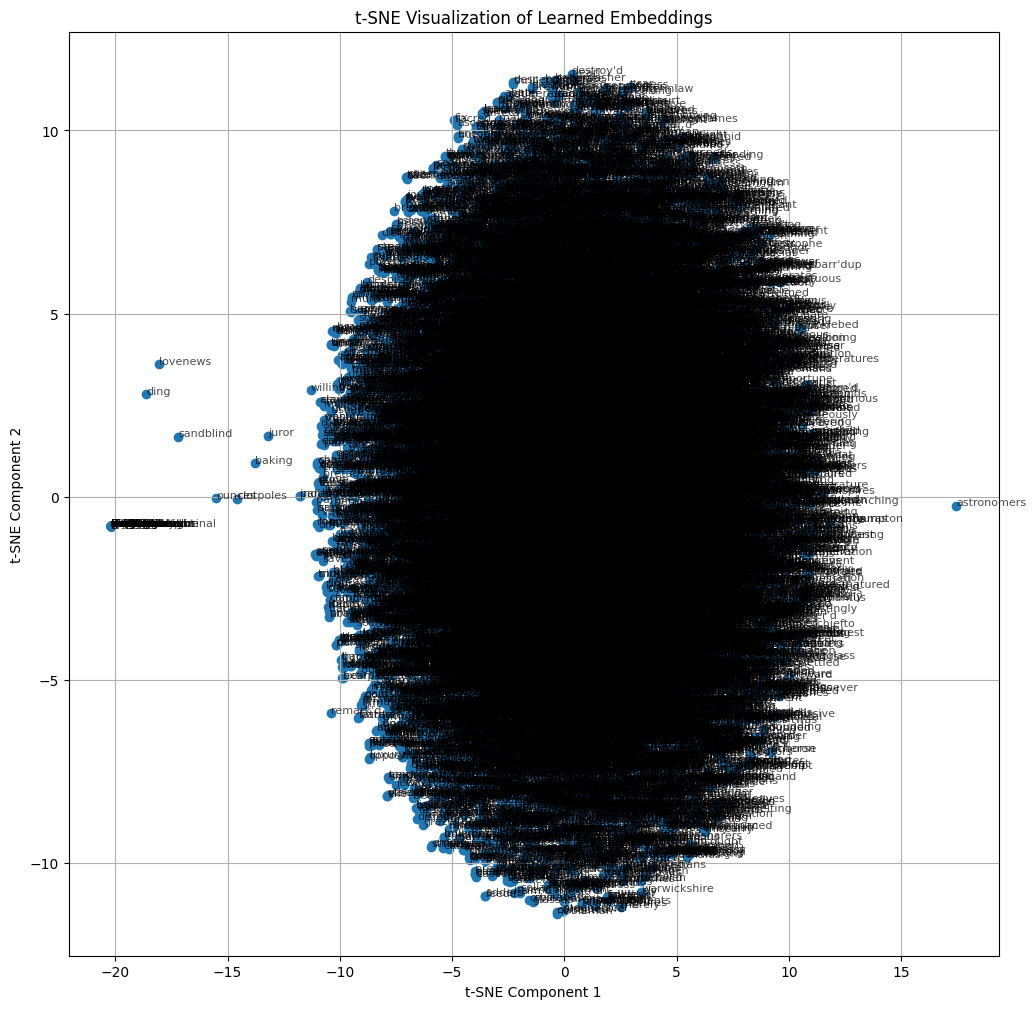

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Extract learned embeddings from the embedding layer
embeddings = model.emb.weight.data.cpu().numpy() 

# Step 1: Reduce dimensionality with PCA
pca = PCA(n_components=50)  
embeddings_pca = pca.fit_transform(embeddings)

# Step 2: Apply t-SNE with Barnes-Hut method
tsne = TSNE(n_components=2, random_state=42, method='barnes_hut', n_iter=500)
embeddings_2d = tsne.fit_transform(embeddings_pca) 

# Prepare labels for the words
idx_to_word = {idx: word for word, idx in word2idx.items()}
labels = [idx_to_word[i] for i in range(len(embeddings))]

# Step 3: Plot the results
plt.figure(figsize=(12, 12))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

for i in range(len(embeddings_2d)):
    plt.annotate(labels[i], xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                 fontsize=8, alpha=0.7)

plt.title('t-SNE Visualization of Learned Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid()
plt.show()
